<a href="https://colab.research.google.com/github/Svsshevch/traffic-sign-project/blob/main/CNN_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git config --global user.name "svsshevch"
!git config --global user.email "svetlanashevchenko@gmax.at"


In [5]:
!git clone https://{token}@github.com/{username}/{repo}

Cloning into 'traffic-sign-project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Libraries

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.ops import nms
import xml.etree.ElementTree as ET
import math
import random
import os

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# !rm -rf GTSRB
# !rm -f GTSRB_Final_Training_Images.zip*

Download dataset

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2026-01-31 23:03:31--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  28.5MB/s    in 7.9s    

2026-01-31 23:03:40 (33.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

# Exploration of dataset

In [ ]:
total_images = 0

for folder in train_folders:
    total_images += len(glob(f"{folder}/*.ppm"))

print("Number of classes:", len(train_folders))
print("Total images in training set:", total_images)

Number of classes: 43
Total images in training set: 39209


## Dataset visualization

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

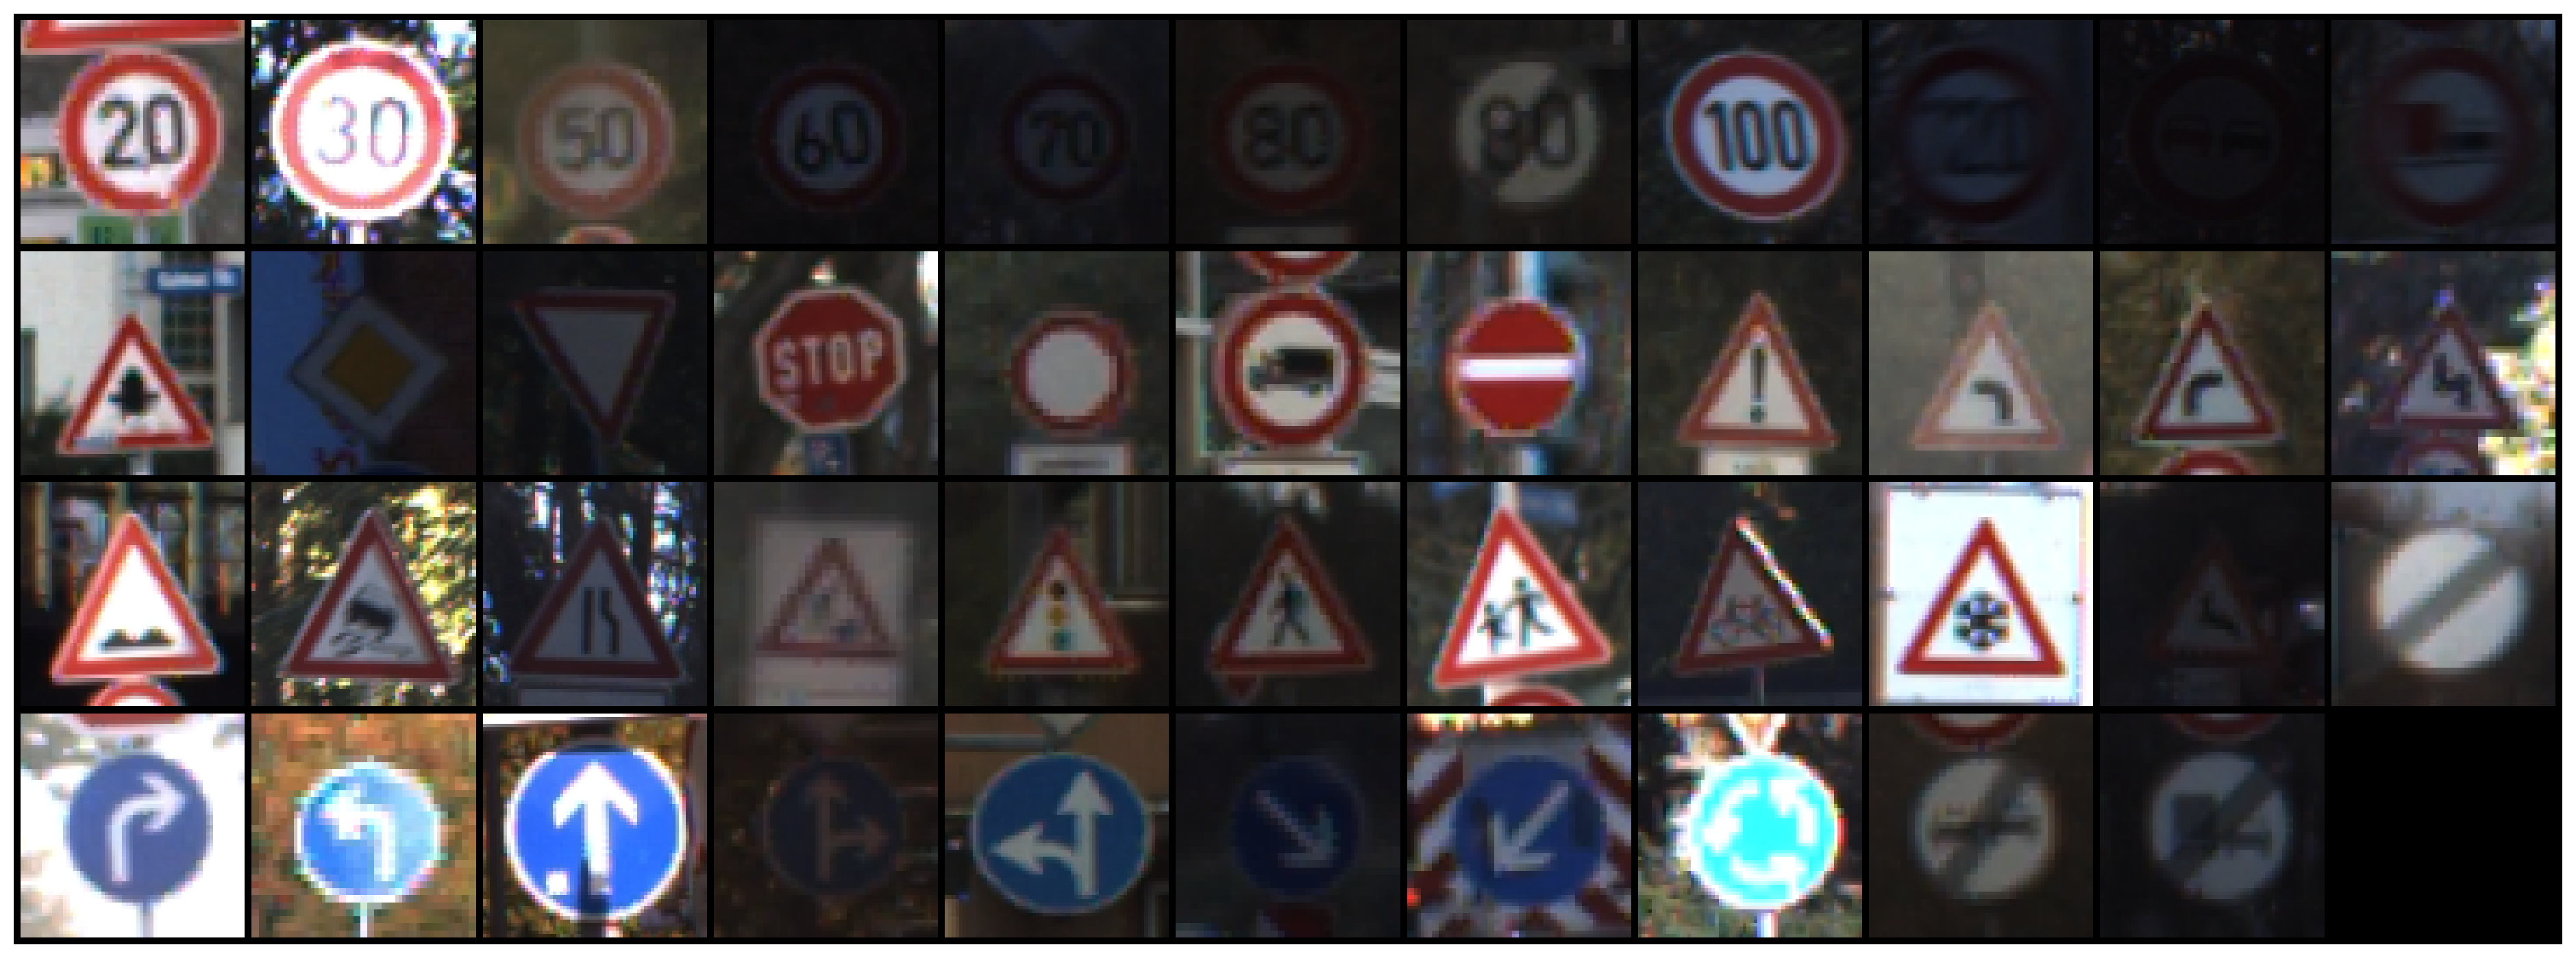

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

## Dataset Distribution

Dataset consists of 43 traffic sign classes with a highly imbalanced class distribution. The number of images per class varies significantly, ranging from 210 images in the smallest classes to 2,250 images in the largest classes. Such imbalance can negatively affect model training by biasing the classifier toward majority classes, potentially reducing performance on underrepresented signs.

Therefore, this dataset requires careful handling, such as:

*   data augmentation for minority classes,
*   class-balanced sampling.





Average per class: 912
Max: 2250 (class 2)
Min: 210 (class 0)
Standard deviation: 688


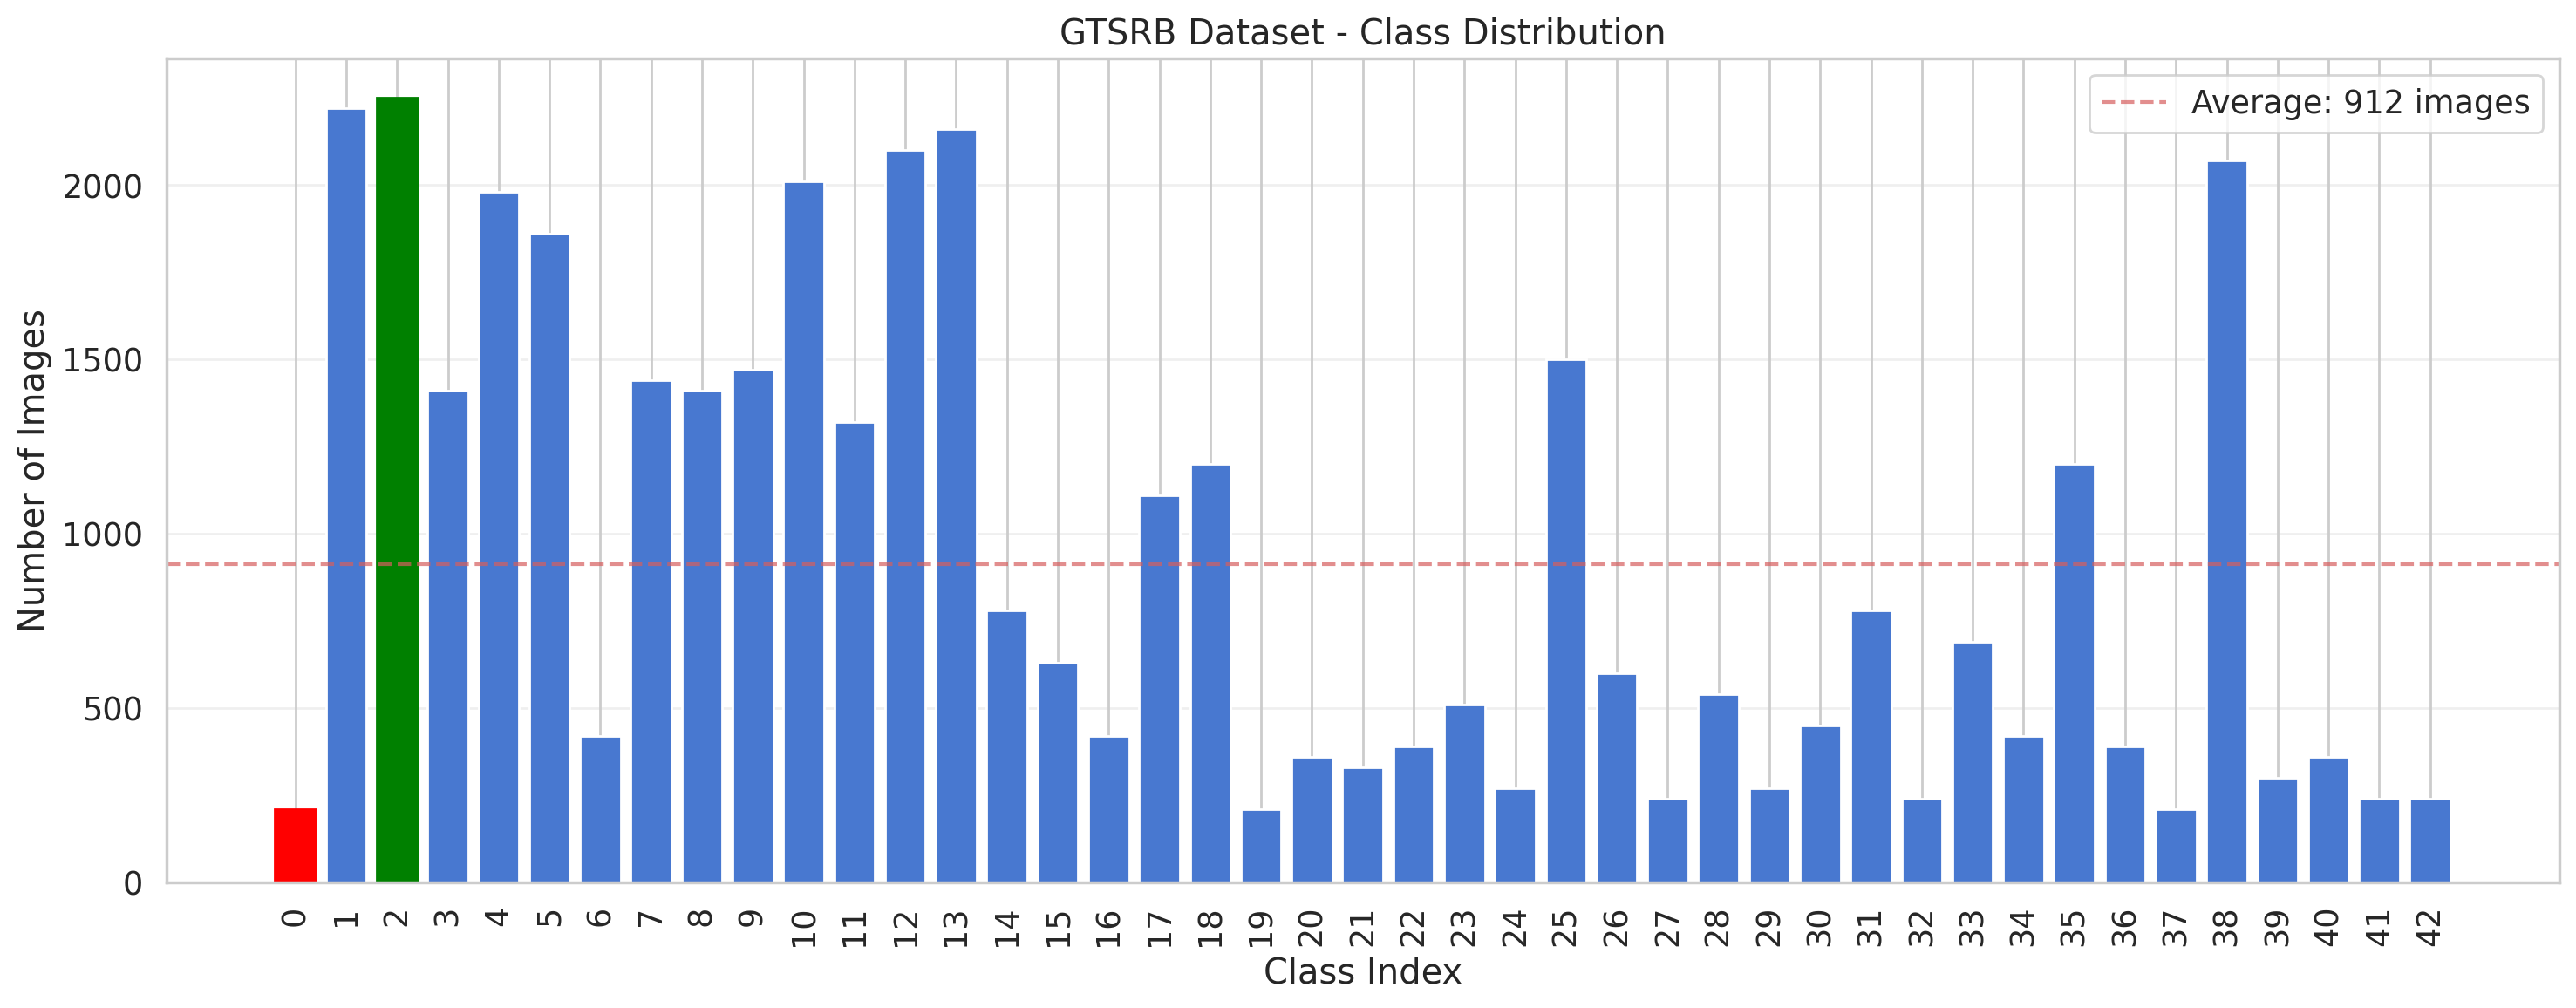

In [ ]:
def plot_class_distribution(train_folders, class_names=None):
    class_counts = []
    labels = []

    for i, folder in enumerate(train_folders):
        image_paths = glob(f'{folder}/*.ppm')
        count = len(image_paths)
        class_counts.append(count)
        if class_names and i < len(class_names):
            labels.append(f"{i}: {class_names[i]}")
        else:
            labels.append(str(i))

    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(len(class_counts)), class_counts)
    plt.xlabel('Class Index')
    plt.ylabel('Number of Images')
    plt.title('GTSRB Dataset - Class Distribution')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.grid(True, alpha=0.3, axis='y')

    total = sum(class_counts)
    avg = np.mean(class_counts)
    plt.axhline(y=avg, color='r', linestyle='--', alpha=0.7,
                label=f'Average: {avg:.0f} images')

    max_idx = np.argmax(class_counts)
    min_idx = np.argmin(class_counts)
    bars[max_idx].set_color('green')
    bars[min_idx].set_color('red')

    plt.legend()
    plt.tight_layout()

    print(f"Average per class: {avg:.0f}")
    print(f"Max: {max(class_counts)} (class {max_idx})")
    print(f"Min: {min(class_counts)} (class {min_idx})")
    print(f"Standard deviation: {np.std(class_counts):.0f}")

    return class_counts

class_distribution = plot_class_distribution(train_folders)

We analyze image size distribution to choose a suitable crop/resize resolution

Scanning image sizes: 100%|██████████| 43/43 [00:00<00:00, 250.04it/s]


Images analyzed: 2150
Mean resolution: 50.4 x 49.7 (W x H) pixels
Min/Max width:  25 / 221 px
Min/Max height: 25 / 195 px


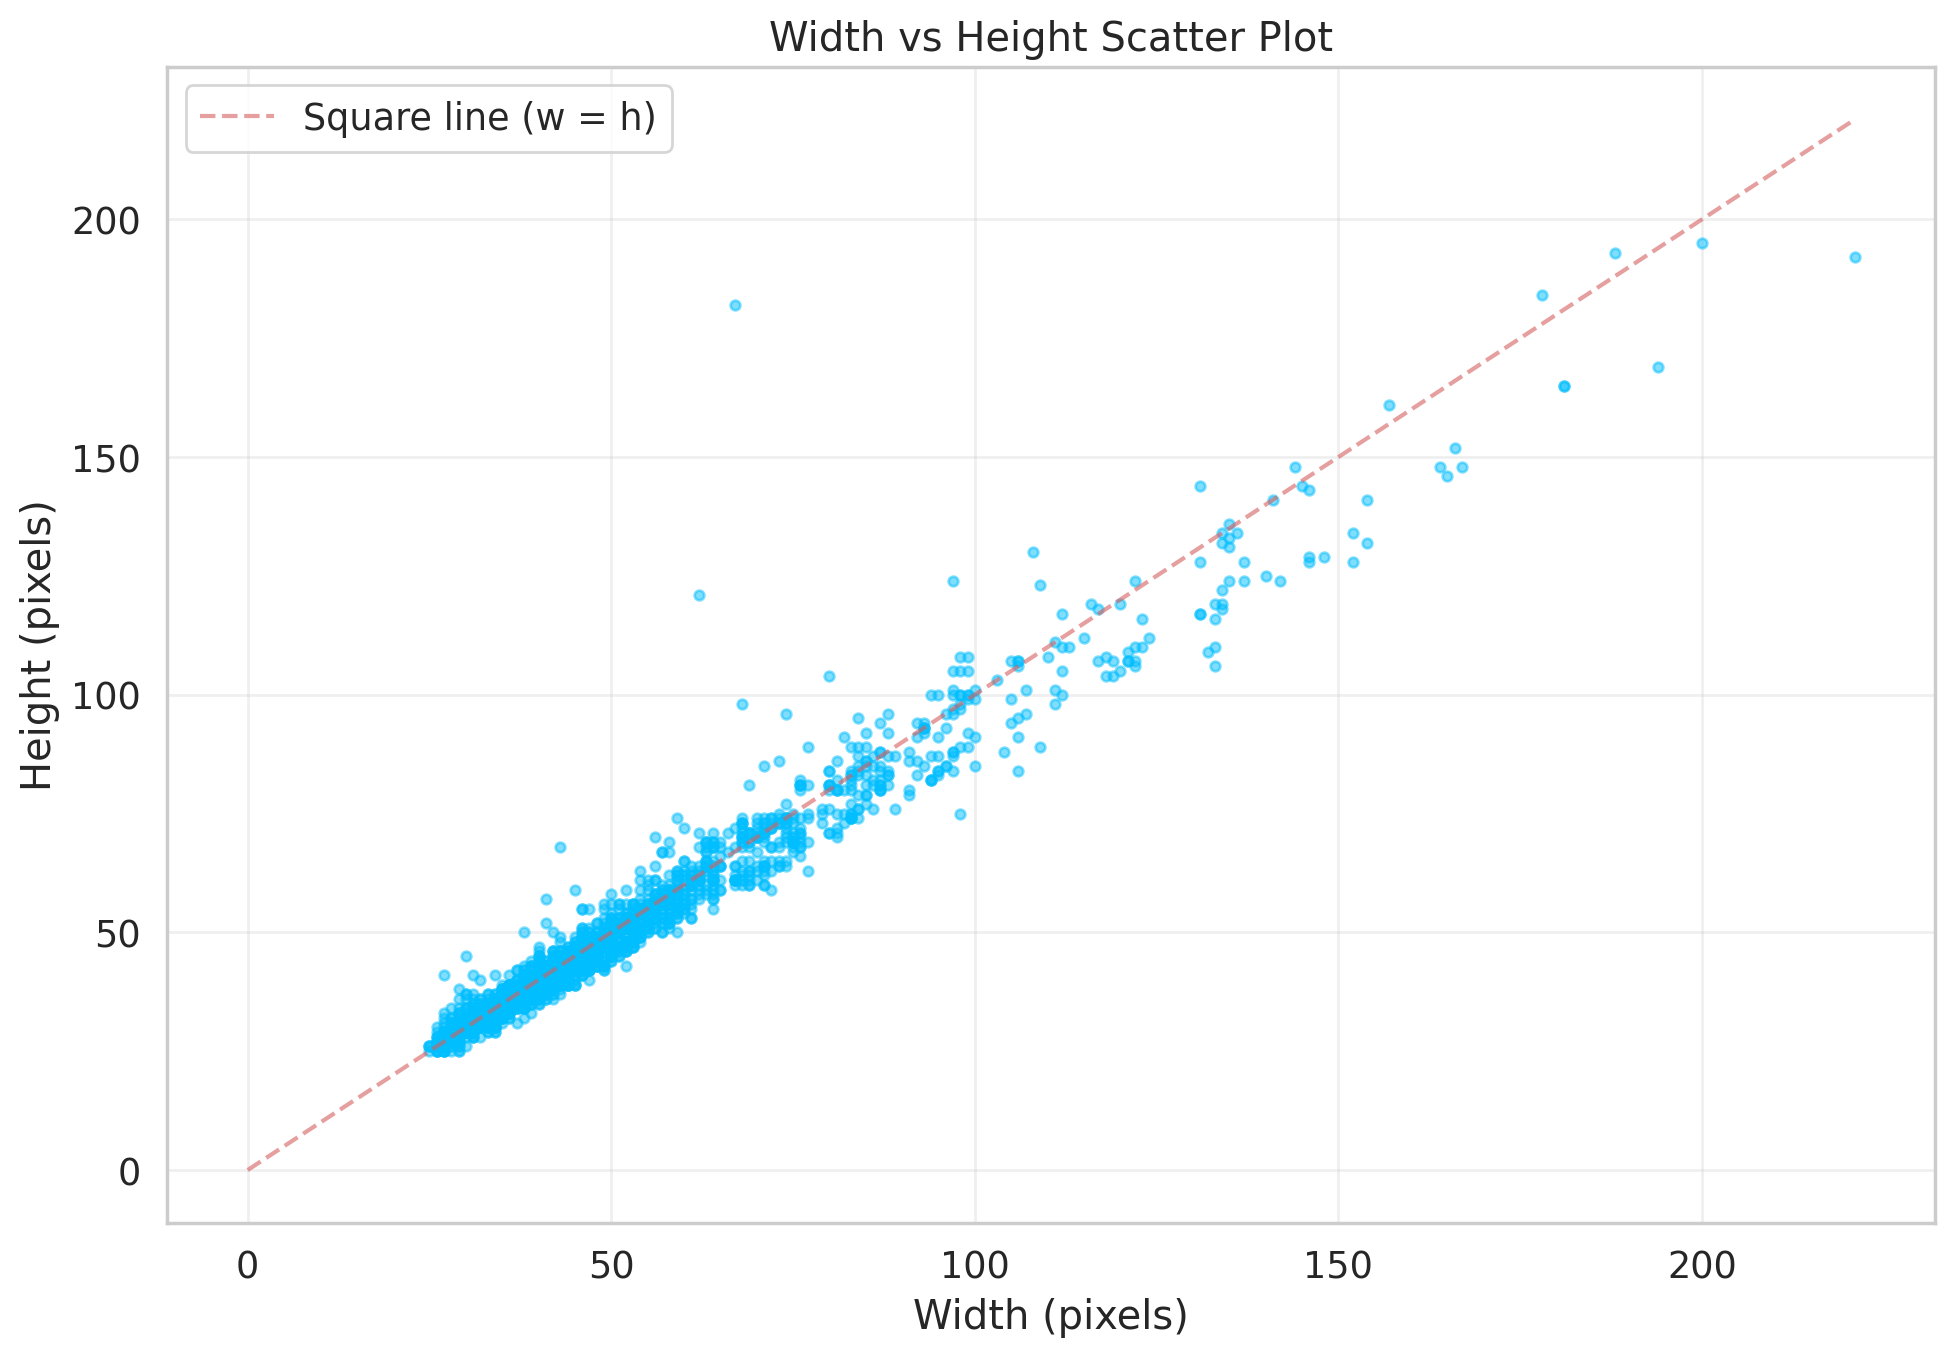

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_mean_size_and_scatter(train_folders, max_imgs_per_class=50):

    folders = train_folders

    widths, heights = [], []

    for folder in tqdm(folders, desc="Scanning image sizes"):
        for img_path in glob(f"{folder}/*.ppm")[:max_imgs_per_class]:
                with Image.open(img_path) as img:
                    w, h = img.size
                widths.append(w)
                heights.append(h)

    widths = np.array(widths)
    heights = np.array(heights)

    mean_w = widths.mean()
    mean_h = heights.mean()

    print(f"Images analyzed: {len(widths)}")
    print(f"Mean resolution: {mean_w:.1f} x {mean_h:.1f} (W x H) pixels")
    print(f"Min/Max width:  {widths.min()} / {widths.max()} px")
    print(f"Min/Max height: {heights.min()} / {heights.max()} px")

    plt.figure(figsize=(10, 7))
    plt.scatter(widths, heights, s=12, alpha=0.5)
    plt.title("Width vs Height Scatter Plot")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    max_side = max(widths.max(), heights.max())
    plt.plot([0, max_side], [0, max_side], "r--", alpha=0.6, label="Square line (w = h)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mean_w, mean_h

mean_w, mean_h = analyze_mean_size_and_scatter(train_folders)

## Building a dataset

Define names for our classes

In [ ]:
class_names = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]
class_indices = list(range(43))

We create the train, validation, and test splits for the dataset. For each class, the images are shuffled and split into 80% training data, 10% validation data, and 10% test data

In [ ]:
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

In [ ]:
for i, cls_index in enumerate(class_indices):

    image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
    if len(image_paths) == 0:
        print(f"No images in {train_folders[cls_index]}")
        continue

    class_name = class_names[i]

    #Shuffle and split
    np.random.shuffle(image_paths)
    split_points = [
        int(0.8 * len(image_paths)),
        int(0.9 * len(image_paths))
    ]
    ds_split = np.split(image_paths, indices_or_sections=split_points)

    #Process splits
    for ds, images in zip(DATASETS, ds_split):
        if len(images) == 0:
            continue

        #New folder
        target_dir = f'{DATA_DIR}/{ds}/{class_name}/'
        os.makedirs(target_dir, exist_ok=True)

        #Copy images
        for img_path in images:
            shutil.copy(img_path, target_dir)

Speed limit (20km/h): 210
Speed limit (30km/h): 2220
Speed limit (50km/h): 2250
Speed limit (60km/h): 1410
Speed limit (70km/h): 1980
Speed limit (80km/h): 1860
End of speed limit (80km/h): 420
Speed limit (100km/h): 1440
Speed limit (120km/h): 1410
No passing: 1470
No passing for vehicles over 3.5 metric tons: 2010
Right-of-way at the next intersection: 1320
Priority road: 2100
Yield: 2160
Stop: 780
No vehicles: 630
Vehicles over 3.5 metric tons prohibited: 420
No entry: 1110
General caution: 1200
Dangerous curve to the left: 210
Dangerous curve to the right: 360
Double curve: 330
Bumpy road: 390
Slippery road: 510
Road narrows on the right: 270
Road work: 1500
Traffic signals: 600
Pedestrians: 240
Children crossing: 540
Bicycles crossing: 270
Beware of ice/snow: 450
Wild animals crossing: 780
End of all speed and passing limits: 240
Turn right ahead: 689
Turn left ahead: 420
Ahead only: 1200
Go straight or right: 390
Go straight or left: 210
Keep right: 2070
Keep left: 300
Roundabout